<a href="https://colab.research.google.com/github/Pilo1961/Deep_Learning/blob/master/embedding_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

In [0]:
import pickle
with open("/content/drive/My Drive/embeddings_jp/infersent.pkl", 'rb') as f:
  embedding = pickle.load(f) 

In [0]:
def train_test(df):
  x_train = df[df.index % 5 != 0]     # Excludes every 5th row starting from 0
  x_test = df[df.index % 5 == 0]      # Selects every 5th row starting from 0
  return x_train, x_test

In [4]:
df_emb=pd.DataFrame(embedding)
df_emb.head()

emb_train, emb_test= train_test(df_emb)
print(emb_train.shape)
print(emb_test.shape)

(32364, 4096)
(8091, 4096)


In [5]:
from tensorflow.keras.losses import binary_crossentropy
from keras.optimizers import adam
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow.keras.layers import concatenate, Embedding, Dense, Dropout, Reshape, UpSampling2D, Conv2D, BatchNormalization, Activation, Input, Concatenate, LeakyReLU, Flatten, Lambda

Using TensorFlow backend.


In [0]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss

In [11]:
latent_len=1024

# AUX function -- Sampler
def sample_z(args):
    mean, var = args
    batch_size = tf.shape(mean)[0]
    eps = tf.random.normal(shape=(batch_size, latent_len))
    return mean + tf.exp(var) * eps

# Esto se debe de ir a models
#def create_embedding_compressor(len_embedding=20):
'''
Crea la red discrimidaora de la primera etapa
'''
# Q(z|x) -- Define encoder
in_layer = Input(shape=(4096,), name='INPUT')
h_q = Dense(1024, activation='relu', name='H_Q')(in_layer)

mu = Dense(latent_len, activation='linear', name='MU')(h_q)
log_sigma = Dense(latent_len, activation='linear', name='SIGMA')(h_q)

# Espacio latente
z = Lambda(sample_z, name='Z')([mu, log_sigma])

# P(x|z) -- Define decoder
decode_in_layer = Input(shape=(latent_len,), name='IN_DECOD')
decode_hidden = Dense(1024, activation='relu', name='H_P')(decode_in_layer)
decode_out_layer = Dense(4096, activation='sigmoid', name='OUT')(decode_hidden)

encoder = Model(in_layer, z, name='ENCODER')
decoder = Model(decode_in_layer, decode_out_layer, name='DECODER')

# Create full Variational Autoencoder
out_layer = decoder(encoder(in_layer))
vae = Model(in_layer, out_layer, name='VAE')

vae.summary()


#return Model(inputs=[input_layer],outputs=[emb])


Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 4096)]            0         
_________________________________________________________________
ENCODER (Model)              (None, 1024)              6294528   
_________________________________________________________________
DECODER (Model)              (None, 4096)              5248000   
Total params: 11,542,528
Trainable params: 11,542,528
Non-trainable params: 0
_________________________________________________________________


In [31]:
latent_len=1024
# Q(z|x) -- Define encoder
in_layer = Input(shape=(4096,), name='INPUT')
h_q = Dense(latent_len, activation='relu', name='H_Q')(in_layer)

decode_in_layer = Input(shape=(latent_len,), name='IN_DECOD')
decode_out_layer = Dense(4096, activation='sigmoid', name='OUT')(decode_in_layer)

encoder = Model(in_layer, h_q, name='ENCODER')
decoder = Model(decode_in_layer, decode_out_layer, name='DECODER')

# Create full Variational Autoencoder
out_layer = decoder(encoder(in_layer))
vae = Model(in_layer, out_layer, name='VAE')

vae.summary()



Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 4096)]            0         
_________________________________________________________________
ENCODER (Model)              (None, 1024)              4195328   
_________________________________________________________________
DECODER (Model)              (None, 4096)              4198400   
Total params: 8,393,728
Trainable params: 8,393,728
Non-trainable params: 0
_________________________________________________________________


In [0]:
# AUX -- VAE custom loss (DKL + BCE)
def vae_loss(x, x_hat):

    # E[log P(X|z)] - BCE
    reconst = binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_hat))
    # D_KL(Q(z|X) || P(z|X))
    dkl = -0.5 * tf.reduce_sum(1 + log_sigma - tf.square(mu) - tf.exp(log_sigma), axis=-1)
    return reconst + 0.00003 * dkl

In [32]:
# Compile and train
batch_size=100
vae.compile(optimizer='adam', loss='mse', experimental_run_tf_function=False)
history = vae.fit(emb_train, emb_train, epochs=50, batch_size=batch_size, validation_split=0.2)

Epoch 1/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0084 - val_loss: 0.0044
Epoch 2/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 3/50
259/259 [==============================] - 3s 11ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 4/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 5/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 7/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 8/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 10/50
259/259 [==============================] - 3s 12ms/step - loss: 0.0034 - val_lo

In [0]:
import matplotlib.pyplot as plt

# Plot distribution of latent space
x_test_encoded = encoder.predict(emb_test, batch_size=100)
x_train_encoded = encoder.predict(emb_train, batch_size=100)

In [34]:
x_test_encoded[:,:5]

array([[0.10368969, 0.12826093, 0.17225644, 0.25430372, 0.6978054 ],
       [0.        , 0.4913183 , 0.42970124, 0.2662955 , 0.6191561 ],
       [0.        , 0.18445027, 0.32199034, 0.36835104, 0.        ],
       ...,
       [0.        , 0.34447354, 0.29852533, 0.        , 0.        ],
       [0.7424813 , 0.9852868 , 0.03696638, 0.16963893, 0.93767846],
       [0.        , 0.6991482 , 0.14024022, 0.3291487 , 0.9058262 ]],
      dtype=float32)

In [35]:
x_train_encoded.shape

(32364, 1024)

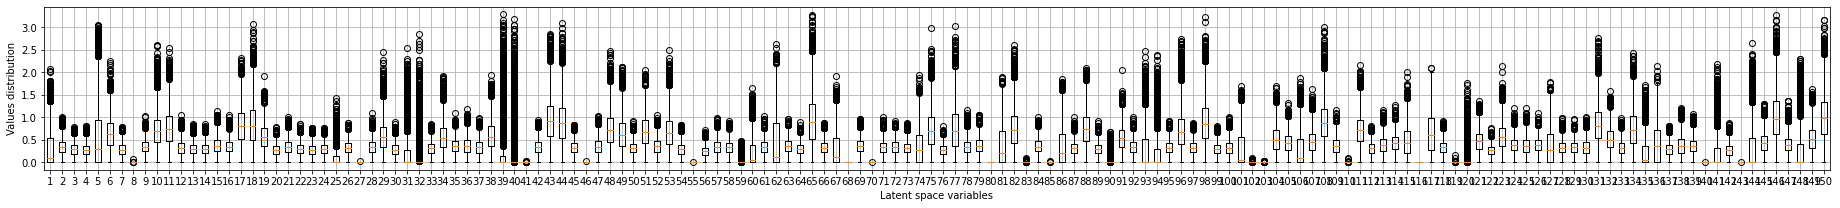

In [36]:
plt.figure(figsize=(32, 3))
plt.boxplot(x_test_encoded[:,:150])
plt.xlabel('Latent space variables')
plt.ylabel('Values distribution')
plt.grid()
plt.show()

In [0]:
  with open("/content/drive/My Drive/embeddings_jp/infersent_1024_encoding.pkl", 'wb') as f:
    pickle.dump(x_train_encoded,f) 